# Technical Appendix

### This complements the technical appendix of the manuscript (and is still a bit work in progress)

In [40]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize, linalg
from scipy.stats import distributions

%matplotlib inline
sns.set_palette('muted')
sns.set_style('whitegrid')

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

# Convolution

In [2]:
def convolve(signal, kernel):
    """
    Compute the convolution of a signal and a kernel in the time-domain.
    This is not how it's done in real applications; using the convolution theorem
    one would multiply in the frequency domain and then take the inverse fourier transform.
    """
    
    n, m = len(signal), len(kernel)
    nconv, npad = m + m - 1, m - 1
    
    res, padding = np.zeros(nconv), np.zeros(npad)
    signal_pad = np.concatenate([padding, signal, padding])
    
    # slide along and compute dot products
    for i in range(nconv):
        res[i] = np.dot(kernel, signal_pad[i:(m+i)]) / m
    
    # the result of convolution is n + m - 1, so let's cap out
    # the uninteresting parts and let it be the same length as the signal
    half = np.floor(m / 2.0)
    return res[half:-half]


def plot_conv(signal, kernel, conv):
    all_three = [signal, kernel, conv]
    comb = np.concatenate(all_three)
    fig, axes = plt.subplots(3, 1, figsize=(4, 6))
    ax1, ax2, ax3 = axes
    
    fig.suptitle('Convolution')
    ax1.plot(signal, 'r', drawstyle='steps-post')
    ax2.plot(kernel, 'g', drawstyle='steps-post')
    ax3.plot(conv, 'b')
    
    for ax in axes:
        #ax.set_yticks([]), ax.set_xticks([])
        ax.set_ylim(np.min(comb) * 1.3, np.max(comb) * 1.3)

    plt.show()

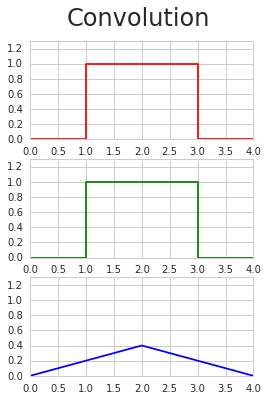

In [3]:
signal = np.array([0, 1, 1, 0, 0])
kernel = np.array([0, 1, 1, 0, 0])
conv = convolve(signal, kernel)

plot_conv(signal, kernel, conv)

# Sine waves and Fourier transform

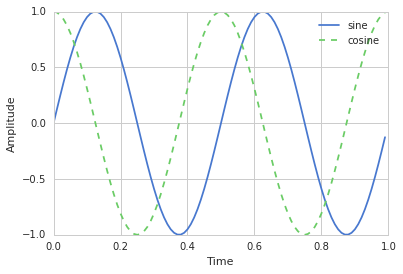

In [4]:
"""
First, a note on sine waves. We can create what is called a complex sine wave
using the code below. This follows from expanding the exponential function (see technical appendix),
i.e., Euler's equality.

The result has a real part (the cosine wave) and a complex part (the sine wave).
Transforming into the polar coordinate system gives power (amplitude^2) and phase, but more below.
"""

freq = 2
srate = 100. # sampling rate
time = np.arange(0, 1, 1 / srate)

sine = np.exp(1j * 2 * np.pi * freq * time) # Euler's formula

plt.plot(time, np.imag(sine), label='sine')
plt.plot(time, np.real(sine), linestyle='dashed', label='cosine')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend();

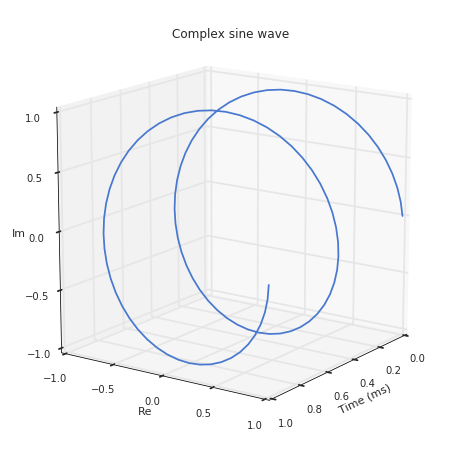

In [5]:
"""
Here we plot the sine wave in complex 3D space, note that the amplitude does not change over time.
"""

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.plot(time, np.real(sine), np.imag(sine))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Re')
ax.set_zlabel('Im')
ax.view_init(15,35)
ax.set_title('Complex sine wave');

In [6]:
def simulate_signal(wave, time):
    """
    Simulate signals based on freq, ampl, phase, saved in a dict called wave.
    """
    
    signal = np.zeros(len(time))
    ampl, freq, phase = wave['ampl'], wave['freq'], wave['phase']
    assert len(ampl) == len(freq) == len(phase)
    
    # sum the imaginary part of a complex sine wave (which is the sine part)
    for i in range(len(freq)):
        sine = ampl[i] * np.exp(1j * 2*np.pi * freq[i] * time + phase[i])
        
        #sine = ampl[i] * np.sin(2*np.pi * freq[i] * time + phase[i])
        signal += np.imag(sine)
    
    return signal

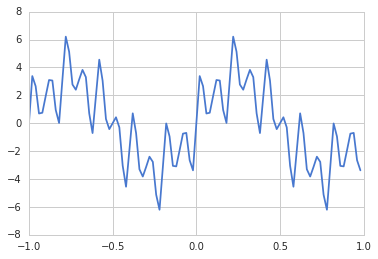

In [7]:
srate = 50.0

wave = {
    'freq': np.array([1, 5, 10, 15]),
    'ampl': np.array([2, 1, 2, .5]),
    'phase': np.array([.5, 0, 0, 0])
}

time = np.arange(-1, 1, 1 / srate)

signal = simulate_signal(wave, time)
plt.plot(time, signal);

In [8]:
def dft(signal, srate):
    """
    Discrete Fourier transform (slow). Decomposes a signal into complex sine waves.
    
    For a more concise implementation using linear algebra,
    see http://greenteapress.com/thinkdsp/html/thinkdsp008.html
    
    The maximum frequency component is equal to the length of the signal. ???
    """
    
    # number of time points
    N = len(signal)
    
    # time used for sine waves
    fouriertime = np.arange(0, N, dtype='float64') / N
    
    # result of the transform are N complex fourier coefficients
    coefs = np.zeros(N, dtype='complex')
    
    for k in range(N):
        sine = np.exp(-1j*2*np.pi*k*fouriertime)
        
        # measures the similarity of the specific sine wave and our signal
        coefs[k] = np.sum(signal * sine)
        
    return coefs / N


def extract(fourier):
    """
    Extract power (amplitude^2) and phase from the fourier coefficients, i.e. convert
    to polar coordinates.
    
    power = real^2 + imag^2       or np.abs(coefs)**2
    \theta = arctan(real / imag)  or np.phase(coefs)
    """
    
    re, im = np.real(coefs), np.imag(coefs)
    power = re**2 + im**2
    phase = np.arctan2(im, re)
    
    return power, phase

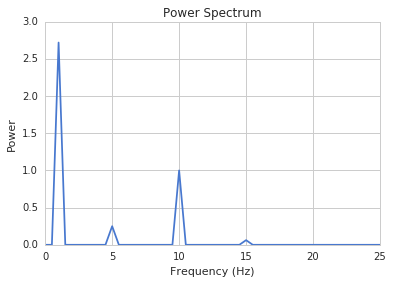

In [9]:
# all the frequencies we can map because of the Nyqvist-Shannon restriction
N = len(signal)
nyqvist = srate / 2.0
freq = np.linspace(0, nyqvist, np.floor(N / 2) + 1)

coefs = dft(signal, srate)
power, _ = extract(coefs)

plt.plot(freq, power[:len(freq)])
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power');

In [11]:
def invdft(coefs):
    """
    Inverse discrete Fourier transform (slow). Creates a signal out of the fourier coefficients.
    """
    
    N = len(coefs)
    sine = np.zeros([N, N], dtype='complex')
    fouriertime = np.arange(0, N, dtype='float64') / N
    
    for i in range(N):
        sine[i, :] = coefs[i] * np.exp(1j * (2*np.pi*i*fouriertime))
        
    return sine.sum(0)

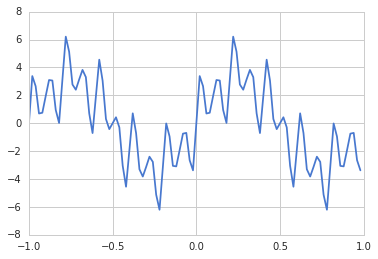

In [12]:
plt.plot(time, invdft(coefs));

# Wavelets and Time-Frequency decomposition

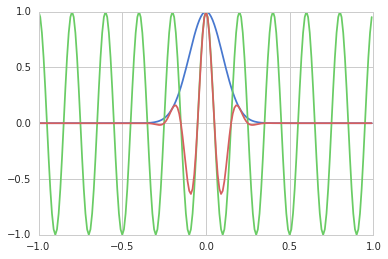

In [13]:
s = .1
freq = 5
srate = 100.0
time = np.arange(-1, 1, 1 / srate)

sin = 1*np.exp(1j * 2*np.pi*freq*time) # sine wave
gauss = np.exp(-.5 * (time**2 / s**2)) # gaussian window
morlet = sin * gauss

plt.plot(time, gauss)
plt.plot(time, sin)
plt.plot(time, morlet); # per default, plots the real part

In [14]:
def create_morlet(freq, wavetime, s=1):
    """
    Create a morlet wavelet. The frequency of the sine wave part determines
    at what frequency we look at, while the width of the gaussian window determines
    the temporal resolution when subsequently doing a wavelet transform of the EEG signal.
    Wide windows yield bad temporal (but good frequency) resolution, while narrow windows yield
    good temporal (but bad frequency) resolution.
    """
    
    sin = np.exp(1j * 2*np.pi*freq*wavetime)
    gauss = np.exp(-.5 * ((wavetime)**2 / s**2))
    return sin * gauss

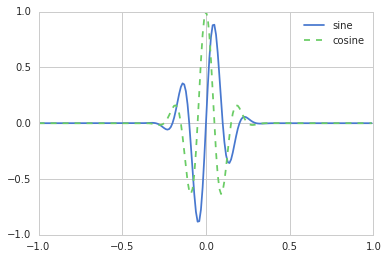

In [15]:
"""
Let's have a more detailed look to check the imaginary and real part.
Similar to the sine waves above, the imaginary component (the sine part) is phase shifted.
"""

plt.plot(time, np.imag(morlet), label='sine')
plt.plot(time, np.real(morlet), linestyle='dashed', label='cosine')
plt.legend();

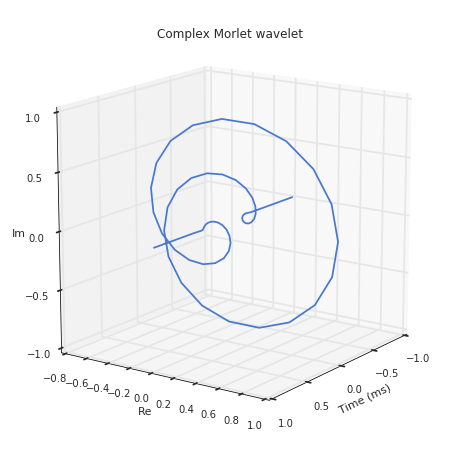

In [16]:
"""
In contrast to the complex sine wave above, this wavelet does in fact change amplitude over time.
"""

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.plot(time, np.real(morlet), np.imag(morlet))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Re')
ax.set_zlabel('Im')
ax.view_init(15,35)
ax.set_title('Complex Morlet wavelet')

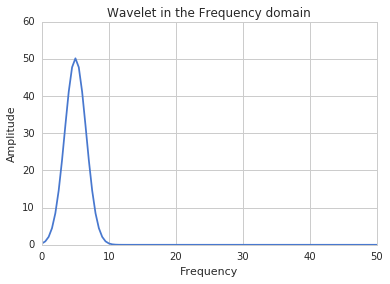

In [17]:
"""
How does the morlet wavelet look in the frequency domain? It's a Gaussian!
The standard deviation of this Gaussian is related to the standard deviation we specified above.

=> this means that when we compute the convolution of a morlet wavelet with an EEG signal, the former acts as
a bandpass filter (both low and high frequency components get attenuated), because convolution in the
time-domain corresponds to multiplication in the frequency-domain.
"""

hz = np.linspace(0, srate/2, np.floor(len(time)/2.) + 1);
fourier = np.fft.fft(morlet)

plt.plot(hz, 2*np.abs(fourier[:len(hz)]))
plt.ylabel('Amplitude')
plt.xlabel('Frequency');
plt.title('Wavelet in the Frequency domain');

Computing the convolution of the EEG signal and a complex morlet wavelet provides us with three important pieces of information, across time (!): power, phase angle, and the band-pass filtered EEG signal.

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
Converting time column to int64...


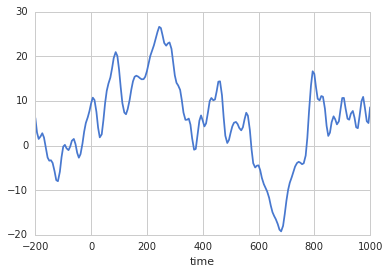

In [18]:
"""
Let's load some data to do wavelet transform on (you might want to read the notebook "example_analysis" first)
"""

import mne
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames]
raw = concatenate_raws(raw_files)
raw.rename_channels(lambda x: x.strip('.'))


raw.filter(1, 30, copy=False) ## bandpass filter

# get the events (stimulus presentation)
events = find_events(raw, shortest_event=0, stim_channel='STI 014')
events[:10, :]

# extract the epochs based on the raw data and events (hand and feet motor imagery)
tmin, tmax = -.200, 1. # start time before an event, end time after an event
event_id = {'hands': 2, 'feet': 3}
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

# just look at one channel
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=[2],
                baseline=(tmin, 0), preload=True, add_eeg_ref=False, verbose=False)

EEG = epochs.average().to_data_frame()
EEG.plot(legend=False);

In [19]:
"""
Wavelet sampling rate must be the same as the data sampling rate.
Wavelets must be centered; i.e., np.arange(x, -x, 1 / srate)
"""

from numpy.fft import fft, ifft

def convolve_morlet(signal, morlet):
    """
    Compute the convolution of a signal and a morlet wavelet in the frequency
    domain via multiplication.
    """
    
    # length of the convolution result
    nconv = signal.size + morlet.size - 1
    
    fft_morlet = fft(morlet, n=nconv)
    fft_morlet = fft_morlet / np.max(fft_morlet) # scale so units don't change
    conv = ifft(fft(signal, nconv) * fft_morlet, n=nconv)
    
    ## the length of the convolution is greater than the original signal, so we have to
    ## remove half the signal size at the beginning and end of the convolution result
    morlet_half = morlet.size / 2
    return conv[morlet_half-1:-morlet_half]

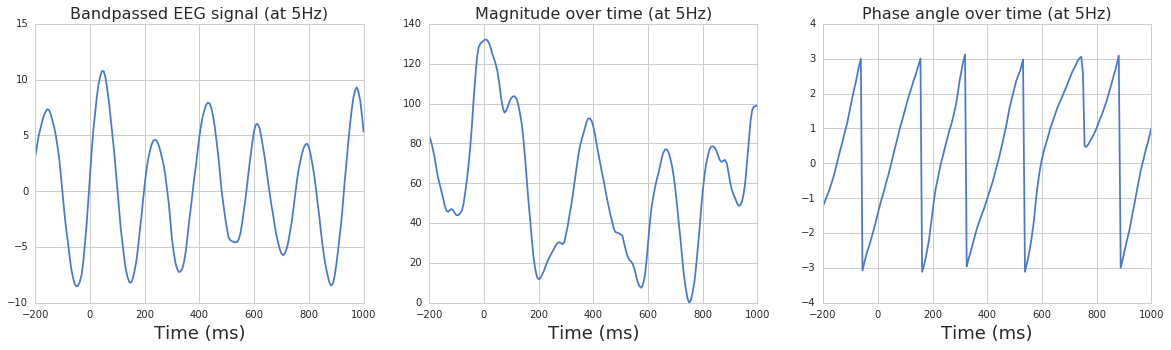

In [20]:
"""
Here we compute the convolution of a complex morlet wavelet and the averaged EEG signal.
The result holds three important pieces of information: the bandpassed signal in time (projection
onto the real axis), the amplitude over time (np.abs(coefs)), and the phase over time (np.angle(coefs);
note that phase is a circular measure). The information is specific for the frequency of our wavelet.
"""

# some wavelet parameters
freq = 5
srate = raw.info.get('sfreq') # must be same as EEG sampling frequency
wavetime = np.arange(-.5, .5, 1.0 / srate) # wavelet must be centered

time = np.array(EEG.index)
signal = np.array(EEG.iloc[:, 0])
morlet = create_morlet(freq, wavetime)

# get a time series of dot products, from which we can extract the information
conv = convolve_morlet(signal, morlet)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = ax

ax1.plot(time, np.real(conv))   # bandpassed filter over time
ax2.plot(time, np.abs(conv)**2)    # amplitude over time
ax3.plot(time, np.angle(conv)) # phase over time

ax1.set_title('Bandpassed EEG signal (at {0}Hz)'.format(freq), fontsize=16)
ax2.set_title('Magnitude over time (at {0}Hz)'.format(freq), fontsize=16)
ax3.set_title('Phase angle over time (at {0}Hz)'.format(freq), fontsize=16);
map(lambda x: x.set_xlabel('Time (ms)', fontsize=18), ax);

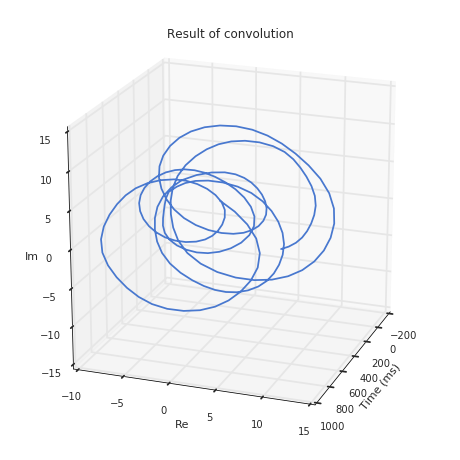

In [21]:
# in three dimensional space, it looks like this!

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.plot(time, np.real(conv), np.imag(conv))
ax.view_init(20, 20)
ax.set_ylabel('Re')
ax.set_zlabel('Im')
ax.set_xlabel('Time (ms)')
ax.set_title('Result of convolution');

In [22]:
"""
Now, we do a time-frequency decomposition on single-trials and then average. Concretely, we specify
a frequency range [0 - 30] and convolve the concatenated single-trials with a complex morlet wavelet
for each frequency in the frequency range. Subsequently, we average and plot the result.
"""

def tf_decompose(epochs, freqs, range_cycles, srate, baseline=None):
    """
    Time-frequency decompose the EEG signal.
    """
    
    # unnecessary restriction, but let's keep it simple
    EEG = epochs.to_data_frame().reset_index('epoch')
    assert EEG.columns.size == 2, 'Only tf decompose one channel!'
    
    channel = np.array(EEG.iloc[:, 1].tolist()) # all the channel data
    trial_time = np.array(EEG.reset_index('time').time.tolist()) # rather ugly way of getting it
    
    ntrials = EEG.epoch.unique().size # number of trials
    npoints, _ = EEG.loc[EEG.epoch == 1, :].shape # number of time points in a trial
    ntotal = ntrials * npoints # number of total samples
    
    nfreqs = len(freqs)
    cmin, cmax = range_cycles
    cycles = np.logspace(np.log10(cmin), np.log10(cmax), nfreqs) / (2*np.pi*np.array(freqs))
    
    wavetime = np.arange(-.5, .5, 1.0 / srate)
    nconv = ntotal + len(wavetime) - 1
    
    fft_channel = fft(channel, n=nconv)
    half_morlet = len(wavetime) / 2
    
    # result of the decomposition, doing it over the concatenated trials for speed
    time_frequency = np.zeros([nfreqs, npoints])
    
    def closest(X, p):
        dist = X - p
        return np.argmin(dist**2)
    
    bmin, bmax = [closest(trial_time, x) for x in baseline]
    
    for i in range(nfreqs):
        f, s = freqs[i], cycles[i]
        morlet = np.exp(1j * 2*np.pi*f*wavetime) * np.exp(-.5 * (wavetime**2 / s**2))
        
        fft_morlet = fft(morlet, n=nconv)
        fft_morlet = fft_morlet / np.max(fft_morlet) # scale so units don't change
        
        conv = ifft(fft_channel * fft_morlet, n=nconv)
        conv = conv[half_morlet-1:-half_morlet]
        
        # cut up the whole convolution result into trials
        conv_trials = conv.reshape((npoints, ntrials))
        mean_power = (np.abs(conv_trials)**2).mean(1)
        
        if baseline:
            base_power = mean_power[bmin:bmax]
            mean_power = 10 * np.log10(mean_power / np.mean(base_power))
        
        # take the mean over trial power
        time_frequency[i, :] = mean_power
        
    return time_frequency

In [23]:
EEG = epochs.to_data_frame().reset_index('epoch')
channel = np.array(EEG.iloc[:, 1].tolist()) # alle the channel data
freqs = np.arange(1, 10)
range_cycles = np.array([4, 7])
tf = tf_decompose(epochs, freqs, range_cycles, raw.info.get('sfreq'), baseline=[-200, 0])

Converting time column to int64...
Converting time column to int64...


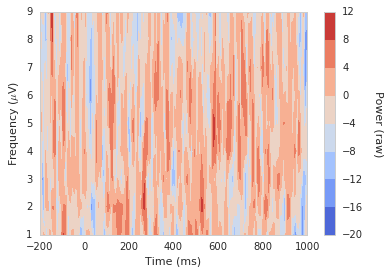

In [24]:
cont = plt.contourf(time, freqs, tf, cmap=plt.cm.coolwarm);
cbar = plt.colorbar(cont);
cbar.set_label('Power (raw)', rotation=270, labelpad=20);
plt.xlabel('Time (ms)')
plt.ylabel('Frequency ($\mu$V)');

# Principal Component Analysis

In [25]:
"""
TODO for all methods: apply to EEG data

different ways to compute the covariance matrix (from the ERP, from all time points from all trials, for each trial
and then averaging; see Cohen, 2014, pp. 293) and applying PCA (over all conditions, for conditions individually)
"""

def standardize(X):
    return X - np.mean(X, axis=0)


def covariance(X):
    n, _ = X.shape
    X = standardize(X)
    return np.dot(X.T, X) / n


def invsqrtm(S):
    return linalg.inv(linalg.sqrtm(S))


def PCA(X, keep=None):
    """
    Principal Component Analysis.
    """
    
    n, p = X.shape
    X = standardize(X)
    S = covariance(X)
    
    eigvals, E = linalg.eig(S)
    variance = eigvals / np.sum(eigvals)
    
    # optionally reduce the dimension of the dataset
    if keep is not None:
        k = np.argmax(np.cumsum(variance) > keep) or p
        E = E[:, :k]
    
    return np.dot(X, E)

np.random.seed(1)

y = np.random.randn(100)
b = np.random.randn(10)
X = np.random.randn(100, 10)
Y = PCA(X, keep = 1)

# Independent Component Analysis

In [26]:
def prewhiten(X):
    X = standardize(X)
    S = covariance(X)
    return invsqrtm(S).dot(X.T)


def ICA(X):
    """
    Independent Component Analysis.
    """
    
    n, d = X.shape
    X = standardize(X)
    S = covariance(X)
    
    eigvals, E = linalg.eig(S)
    D = np.diag(eigvals)
    
    # whiten the data and normalize
    Xw = np.sqrt(linalg.inv(D)).dot(E.T).dot(X.T)
    
    # optimize kurtosis instead of information-theoretically based measures
    kurtosis = (np.tile(np.sum(Xw * Xw, axis=0), [d, 1]) * Xw).dot(Xw.T)
    U, s, Vh = linalg.svd(kurtosis)
    
    W = Vh.T.dot(Xw)
    s = W.dot(X)
    
    return W, s


W, s = ICA(X)

# Linear Discriminant Analysis

In [41]:
def LDA(y, X, pi0=.5, pi1=.5):
    assert pi0 + pi1 == 1
    
    n = len(y)
    result = np.zeros(n)
    n1, n2 = np.bincount(y)
    
    X0, X1 = X[y == 0, :], X[y == 1, :]
    mu0, mu1 = X0.mean(0), X1.mean(0)
    C0, C1 = np.cov(X0.T), np.cov(X1.T)
    C = (C0 + C1) / 2
    Cinv = linalg.inv(C)
    
    def decide(x):
        return (np.log(pi0/pi1) +
                x.dot(Cinv).dot(mu0 - mu1) -
                0.5 * (mu0 + mu1).dot(Cinv).dot(mu0 - mu1))
    
    for i in range(n):
        result[i] = np.exp(decide(X[i, :])) <= .5
        
    return result


n = 1000
y = np.random.binomial(1, .5, size=n)
X = np.random.multivariate_normal(np.random.randn(10), np.random.randn(10, 10), size=n)

# Linear Regression

In [44]:
def linreg(y, X):
    """
    Closed form solution to linear regression.
    """
    S = np.dot(X.T, X)
    return np.dot(linalg.inv(S), np.dot(X.T, y))


def ridge(y, X, lamb):
    """
    Ridge regression has a closed form solution.
    """
    
    n, p = X.shape
    S = np.dot(X.T, X) + np.diag([lamb] * p)
    return np.dot(linalg.inv(S), np.dot(X.T, y))


def lasso(y, X, lamb):
    """
    Lasso does not have a closed form solution, so we use
    constrained optimization utilizing scipy.
    """
    
    n, p = X.shape
    b0 = np.random.rand(p)
    
    def loss(b):
        z = (y - np.dot(X, b))
        return np.dot(z, z) + lamb * sum(abs(b[1:]))
    
    return optimize.minimize(loss, b0)['x']


linear = linreg(y, X)
rid = ridge(y, X, 3)
las = lasso(y, X, 3)

np.array(np.round([linear, rid, las], 3)).T

array([[-0.594,  0.045,  0.058],
       [-2.242, -0.061, -0.055],
       [ 1.287, -0.008, -0.   ],
       [ 0.5  , -0.022, -0.029],
       [-0.16 ,  0.162,  0.17 ],
       [-2.   ,  0.004,  0.   ],
       [ 0.109,  0.087,  0.079],
       [-0.668,  0.016,  0.009],
       [-0.688, -0.016, -0.   ],
       [ 0.312, -0.027, -0.   ]])

# Linear mixed effects models

# Splines and Generalized Additive Models